In [30]:
import sklearn
from sklearn import *
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import tensorly as tl
import scipy

In [31]:
path = "./data_3_variables/"
n_person = 10
n_view = 9
n_illum = 6
x_size = 200
y_size = 200

images = np.empty((n_person, n_view, n_illum, x_size, y_size))
for im_name in os.listdir(path):
    parsed = im_name.split("_")
    person = int(parsed[0])
    view   = int(-int(parsed[1])/4)
    illum  = int(int(parsed[4])/15)-1
    images[person, view, illum] = cv2.resize(cv2.imread( path+im_name, 0), (x_size, y_size))
# images = images.astype("uint8")

-----------------

In [36]:
def MPCA(T, n):
    """ Perform MPCA on the tensor T on the first n dimension of the tensor
        Returns (Z, U, U_T, S, V) where :
            Z is the core tensor
            U is the list of U matrices from the SVD
            U is the list of U^T matrices from the SVD
            S is the list of S matrices from the SVD
            V is the list of V matrices from the SVD
    """
    U = []
    U_T = []
    V = []
    S = []
    for i in range(n):
        u, s, v = np.linalg.svd(tl.base.unfold(T, i), full_matrices=False)
        U.append(u)
        U_T.append(u.T)
        S.append(s)
        V.append(v)
    return (tl.tenalg.multi_mode_dot(images, U_T, np.arange(n)), U, U_T, S, V)

In [37]:
Z, U, U_T, S, V = MPCA(images, 3)

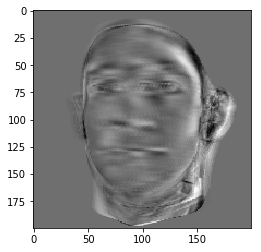

In [56]:
plt.imshow(Z[2,1,0], cmap="gray")

---------------

In [60]:
def MICA(T, n, fun="exp"):
    """ Perform MICA on the tensor T on the first n dimension of the tensor
    """
    Z, U, U_T, S, V = MPCA(T, n)
    W = []
    C = []
    C_1 = []
    for i in range(n):
        w = sklearn.decomposition.fastica_.fastica(tl.base.unfold(T, i), fun=fun)[1]
        W.append(w)
        c = np.dot(U[i], np.linalg.inv(w))
        C.append(c)
        C_1.append(np.linalg.inv(c))
    return tl.tenalg.multi_mode_dot(images, C_1, np.arange(n))

In [61]:
S1 = MICA(images, 3)

/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/adrien/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


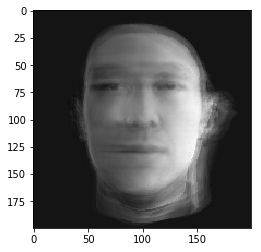

In [66]:
plt.imshow(S1[1,0,0], cmap="gray")